
#### Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()




# Machine learning with JAX part III.
Welcome to the third part of the series on Machine Learning with JAX. Great to see you have already made it this far! In the previous parts we [introduced you to the world of JAX]() and [built a simple machine learning model from scratch using JAX](). In case you are still deciding whether JAX is the right fit for you, you might want to checkout my other blogpost: [5 Reasons to be using JAX for your next machine learning project](). As you developed your skills in the previous posts, earned your first medal and got more exposure within the organization you work for, they asked you to apply ML to a more complex problem. The organization you work for stumbled across a problem that's not linear at all (i.e. not a fancy straight line) and is having difficulties making predictions. Can you help them solve this problem? Are you up for the challenge? Can you handle this slightly more demanding request? I'm sure we can, so lets go. Teamwork makes the dreamwork, (aargh what a cliche).

## Our fictional dataset + problem
In the previous blogpost we worked with a dataset of 63 samples. Mindblowing! Even that is something we'll increase now. Our new dataset is going to be huuuuuuge. One thousand samples (yes, you can take the time to let that sink in ;))! Other than that, there won't be many changes. The number of features will remain the same, just one, and we have a more challenging problem to solve. In particular, your data has the following relationship: $ y_i = f_{w,b}(x_i) = 0.1 * x_1 * cos(x) + noise $. With that, we are ready to simulate some data.


In order to generate this random data, we'll be needing an explicit random key. There is quite some elaborate documentation on why JAX uses an [explicit random key](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#random-numbers) rather than an implicit random key (used by numpy). If you don't want to go over the documentation, here is the gist of it. Explicit random keys make it easier to reason what is being used. This is particularly helpful when updates are happening on different threads, processes and devices. Secondly, JAX uses pure functions (remember). So that's definitely helpfull as well! So let's see how we can generate our data with JAX and a explicit random key.

In [3]:
from typing import Tuple
from jax import random, grad, jit, vmap
import jax.numpy as jnp
import matplotlib.pyplot as plt

In [4]:
# initialize our explicit key
keygen = random.PRNGKey(0)

# specify number of features we have (i.e. 1) and the number of samples we need (i.e. 1000)
n_features_per_sample = 1
n_samples = 1000

# generate some random noise (we are using the explicit key here :))
noise = random.normal(keygen, (n_samples,))

# generate our features
x = jnp.linspace(-10, 10, num=n_samples)

# generate our labels (this corresponds to the function we defined earlier)
y = 0.1 * x * jnp.cos(x) + 0.1 * noise

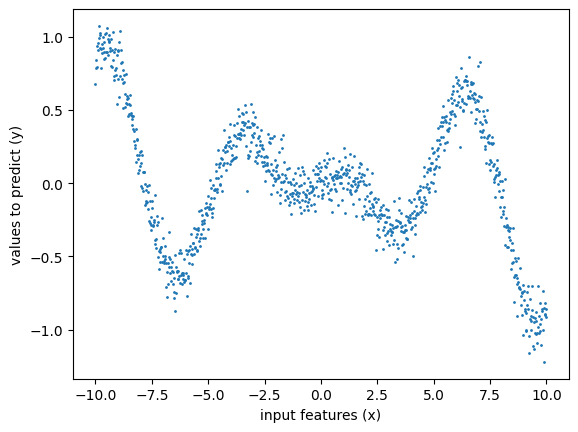

In [5]:
plt.scatter(x, y, s=1)
plt.ylabel("values to predict (y)")
plt.xlabel("input features (x)")
plt.show()

## The model

Now that our data is defined, we can move forward with building our model. You might see something familiar to arise. We are using the exact same process as the one in [ml_with_jax_part_II](). With our data defined, lets see how we can build a multilayer perceptron (MLP). Don't be scared by the term, it's just the same as a feedforward neural network. Again, what we need to keep in mind is that JAX uses pure functions, so the way we define our model is perhaps a bit different than you would expect. Lets see :) 

In [6]:
def init_weights(features_in: int, features_out: int, key: random.PRNGKey, scale=1e-2) -> Tuple[jnp.ndarray, jnp.ndarray]:
    return scale * random.normal(key, shape=(features_in, features_out)), scale * random.normal(key, shape=(features_out,))

def relu(x: jnp.ndarray) -> jnp.ndarray:
    return jnp.maximum(x, 0)

def forward(params, x):
    activations = x
    # for all layers except the last one (as we that won't have a relu activation)
    for weights, bias in params[:-1]:
        activations = relu(jnp.dot(jnp.transpose(weights), activations) + bias)

    output_layer_weights, output_layer_bias = params[-1]
    predictions = jnp.dot(jnp.transpose(output_layer_weights), activations) + output_layer_bias
    return predictions

So what is happening here? Actually, it's quite straightforward. The `def init_weights()` function does exactly that. It initializes our neural network weights (or parameters if you prefer to call them like that). Again, we'll be using an explicit random key to generate these random normally distributed weights (so much randomness in one sentence). Secondly, it takes a scale parameter. This makes sure our loss function will not blow up (but you can forget about that out for now). Good! our weights can now be initialized, next up our neural network! We'll be building a feedforward neural network with a `relu` activation function. The `def forward()` function takes as inputs the models parameters (remember, pure functions!) and a batch x. Then it will compute the activations for all the layers and uses the relu function to enable it to learn about nonlinearity. Finally, for our last layer, we just take the dotproduct and don't apply our relu function. And that's it. Now we can initialize our weights and use that to make a forward call using our model.

Lets test it with some code!

In [7]:

# Specify input_shape + units per layer --> [input_shape, 32, 32, 1]
layers = [n_features_per_sample, 32, 32, 1]

# initialize our weights using the function we just created
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]

# Create a sample and test that we can forward a single example through our network
sample = jnp.array([5])
forward(params, sample)


DeviceArray([-0.00126153], dtype=float32)

Pretty cool! That's working. As you might recall from an earlier post, we can easily transform our model to support batching by leveraging `jax.vmap`. Like so:

In [8]:
# Create a batch
batch = jnp.array([[5], [5]])

# Vectorize our forward function
vforward = vmap(forward, in_axes=(None, 0))

# make a 
pred = vforward(params, batch)
print(pred)

[[-0.00126153]
 [-0.00126153]]


## The cost function + jax.grad

Now that we can make a forward pass, we can start to compute the cost function (and hence, the gradients). The cost function will remain the same as the one we used before: The Mean Squared Error (MSE). The cool new feature we'll introduce is `jax.grad`. This grad function will compute the gradients for us, such that we can update our machine learning model (yay)!.

In [9]:
def mse_cost(params, x, y):
    predictions = vforward(params, x)
    squared_error = (predictions - y) ** 2
    mse = jnp.mean(squared_error)
    return mse

@jit
def update_params(params, x, y, alpha):
    grads = grad(mse_cost)(params, x, y)
    return [
        (w - alpha * dw, b - alpha * db) for (w, b), (dw, db) in zip(params, grads)
    ]

Some things to note here are the following. The `def mse_cost()` is using `vforward`, that is the vectorized implementation (i.e. We use batches :)). Secondly, the `def update_params()` is where we are actually updating our model parameters. It's sort of the same as PyTorch's `backwards()` function, but if your not familiar with that you can forget about it. So what it does is it computes the gradients with respect to the parameters, then it updates the old parameters with the derivative times the the learning rate `alpha`. Cool! Our neat little update function can train a powerful ML model. And as a final remark, we compile the function with `jax.jit` to speed things up a bit, but you could remove this if you'd like and everything would still work. We have all the building blocks in place again! Let's bring them together.

## Training our model

It's time to put the pieces together. Our network will be much larger than the one we trained in the previous blogpost. Our model will have three hidden layers having 128 units each. We'll train our model for 500 epochs on batches of size 64 and with a learning rate of 0.1 (sometimes called alpha). All of this can be changed and you would get different results. Optimizing this is another step people sometimes do to find the best model (its called [hyperparameter tuning/optimization](https://en.wikipedia.org/wiki/Hyperparameter_optimization)).

One thing you might notice is that we reshape our dataset. This is because we will be working with batches! Remember the `vforward` in the `mse_cost` function. In the loop, we'll use our `update` function to update our parameters and hope it will converge to a nice global minimum! Lets start the training.

In [10]:
layers = [n_features_per_sample, 128, 128, 128, 1]
params = [init_weights(features_in, features_out, keygen) for features_in, features_out in zip(layers[:-1], layers[1:])]
learning_rate = 0.1

n_epochs = 500
batch_size = 64
costs = []
n_batches_per_epoch = n_samples // batch_size

# turn both x and y into batches
x = jnp.reshape(x, (x.shape[0], n_features_per_sample))
y = jnp.reshape(y, (y.shape[0], 1))

predictions_at_epochs = []
for epoch in range(n_epochs):

    for batch in range(n_batches_per_epoch):
        x_batch = random.choice(keygen, x, shape=(batch_size,))
        y_batch = random.choice(keygen, y, shape=(batch_size,))
        params = update_params(params, x_batch, y_batch, learning_rate)
        batch_cost = mse_cost(params, x_batch, y_batch)
        costs.append(batch_cost)
    if epoch % 10 == 0:
        y_pred = vforward(params, x)
        predictions_at_epochs.append((y_pred, epoch))
    if epoch % 100 == 0:
        cost_epoch = jnp.mean(jnp.array(costs[-n_batches_per_epoch:]))
        print(f"Epoch: {epoch} Cost: {cost_epoch}")


Epoch: 0 Cost: 0.21011464297771454
Epoch: 100 Cost: 0.20986634492874146
Epoch: 200 Cost: 0.1356569230556488
Epoch: 300 Cost: 0.02712821215391159
Epoch: 400 Cost: 0.017574258148670197


The training loss is definitely decreasing. Let's visualize how to model is performing over time. You can skip the following code. It's just their the show you how are model is gradually becoming better once it sees more data.

In [16]:
import base64
import imageio
import IPython
import tempfile
import os

fps=5
try:
    os.makedirs('../assets/ml_with_jax_part_3/')
except FileExistsError:
    pass
with imageio.get_writer('../assets/ml_with_jax_part_3/training_convergence.gif', mode='I', fps=fps) as writer:

    filenames = []
    with tempfile.TemporaryDirectory() as tempd:
        for predictions_at_epoch in predictions_at_epochs:
            y_preds, epoch = predictions_at_epoch
            filename = os.path.join(tempd, f'results_epoch_{epoch}.png')
            plt.scatter(x, y_preds, s=1, c='g')
            plt.scatter(x, y, s=1, c='b')
            plt.title(f"Epoch: {epoch}")
            plt.savefig(filename)
            plt.clf()
            filenames.append(filename)
        for filename in filenames:
            image = imageio.v3.imread(filename)
            writer.append_data(image)

<Figure size 640x480 with 0 Axes>

If we then visualize the results, we have a pretty awesome graph. We can immediately see that the model converges and starts to fit the data rather nicely! Great job :)  

![Alt Text](https://github.com/Sruinard/machine_learning_novice/blob/main/assets/ml_with_jax_part_3/training_convergence.gif?raw=true)


## Conclusion

Well done if you made it this far! You just tackled an increasingly complex problems and are really getting a hang of this thing called JAX. After generating some data and learning about why JAX uses an explicit random key to generate random data, we moved forward to building our first feedforward neural network. We explored the gradient function present in JAX and built an end-to-end example on training a more complex model from scratch! In fact, you have made such an impact that a recruiter from [SpaceX](https://www.spacex.com/) just reached out to you to help them out with their next challenge: Landing their rockets on the moon with Reinforcement Learning. They even said that you could use the tools you like. As you have always been eager to try out [Deepminds'](https://www.deepmind.com/) library for deep learning [Haiku](https://dm-haiku.readthedocs.io/en/latest/), you decide to join them and take on the next challenge! Do you join me in building an RL agent which can safely land a rocket on the moon? If so, checkout the last blogpost in this series: [ml_with_jax_part_IV]()

## Connect, learn and contribute to help yourself and others land a job in the AI space

Looking for a way to contribute or learn more about AI/ML, connect with me on medium:
- LinkedIn: [https://www.linkedin.com/in/stefruinard/]()
- Medium: [https://medium.com/@stefruinard]()
- GitHub: [https://github.com/Sruinard]()

## Contributors:
###### Submit a Pull Request or reach out on LinkedIn and become a recognized contributor :)